In [2]:
import gdown
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
import numpy as np
import scanpy as sc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from anndata.experimental.pytorch import AnnLoader
#https://anndata-tutorials.readthedocs.io/en/latest/annloader.html

from typing import Callable, Iterator, Union, Optional, TypeVar
from typing import List, Set, Dict, Tuple
from typing import Mapping, MutableMapping, Sequence, Iterable
from typing import Union, Any, cast, IO, TextIO
from my_torch_utils import fnorm, replicate, logNorm, log_gaussian_prob
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.cluster import KMeans
import my_torch_utils as ut


In [14]:
kld = lambda mu, logvar: -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

class SigmaVAE2(nn.Module):
    def __init__(
        self,
        nz: int = 20,
        nh: int = 2*1024,
        nx: int = 28 ** 2,
        ny: int = 2,
    ) -> None:
        super(self.__class__, self).__init__()
        self.nx = nx
        self.ny = ny
        self.nz = nz
        self.nin = nx + ny
        nin = nx + ny
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(nin, nh),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=nh),
            nn.Linear(nh, nh),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=nh),
        )
        self.decoder = nn.Sequential(
            nn.Linear(nz+ny, nh),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=nh),
            nn.Linear(nh, nh),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=nh),
        )
        self.xmu = nn.Sequential(
                nn.Linear(nh,nh),
                nn.LeakyReLU(),
                nn.Linear(nh,nx),
                )
        self.zmu =  nn.Sequential(
                nn.Linear(nh,nh),
                nn.LeakyReLU(),
                nn.Linear(nh,nz),
                )
        self.zlogvar =  nn.Sequential(
                nn.Linear(nh,nh),
                nn.LeakyReLU(),
                nn.Linear(nh,nz),
                )
        #self.log_sigma = torch.nn.Parameter(torch.zeros(1)[0], requires_grad=True)
        # per pixel sigma:
        self.log_sigma = torch.nn.Parameter(torch.zeros(nx), requires_grad=True)

    def reparameterize(self, mu, logsig, ):
        eps = torch.randn(mu.shape).to(mu.device)
        sigma = (logsig).exp()
        return mu + sigma * eps

    def encode(self, x,y):
        w = torch.cat((x,y), dim=1)
        h = self.encoder(w)
        mu = self.zmu(h)
        logvar = self.zlogvar(h)
        return mu, logvar

    def decode(self, z, y):
        w = torch.cat((z,y), dim=1)
        h = self.decoder(w)
        mu = self.xmu(h)
        return mu

    def forward(self, x, y):
        zmu, zlogvar = self.encode(x, y)
        z = self.reparameterize(zmu, 0.5*zlogvar)
        xmu = self.decode(z, y)
        return zmu, zlogvar, xmu

    def reconstruction_loss(self, x, xmu, log_sigma):
        # log_sigma is the parameter for 'global' variance on x
        #result = gaussian_nll(xmu, xlogsig, x).sum()
        result = -log_gaussian_prob(x, xmu, log_sigma).sum()
        return result
    
    def loss_function(self, x, xmu, log_sigma, zmu, zlogvar):
        batch_size = x.size(0)
        rec = self.reconstruction_loss(x, xmu, log_sigma) / batch_size
        kl = kld(zmu, zlogvar) / batch_size
        return rec, kl

    def fit(self, train_loader, num_epochs=10, lr=1e-3,
            optimizer = None):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.to(device)
        if not optimizer:
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in range(10):
            #for idx, (data, labels) in enumerate(train_loader):
            for idx, data in enumerate(train_loader):
                self.train()
                self.requires_grad_(True)
                optimizer.zero_grad()
                log_sigma = ut.softclip(self.log_sigma, -2, 2)
                #self.log_sigma.fill_(log_sigma)
                #x = data.flatten(1).to(device)
                x = data.X.float().to(device)
                y = data.obs['subtissue']
                ytarget = torch.argmax(y, dim=1)
                zmu, zlogvar, xmu = self.forward(x,y)
                rec, kl = self.loss_function(x, xmu, log_sigma, zmu, zlogvar)
                loss = rec + kl
                loss.backward()
                optimizer.step()
                if idx % 300 == 0:
                    print("loss = ",
                            loss.item(),
                            kl.item(),
                            rec.item(),
                            )
        self.cpu()
        optimizer = None
        print('done training')
        return None

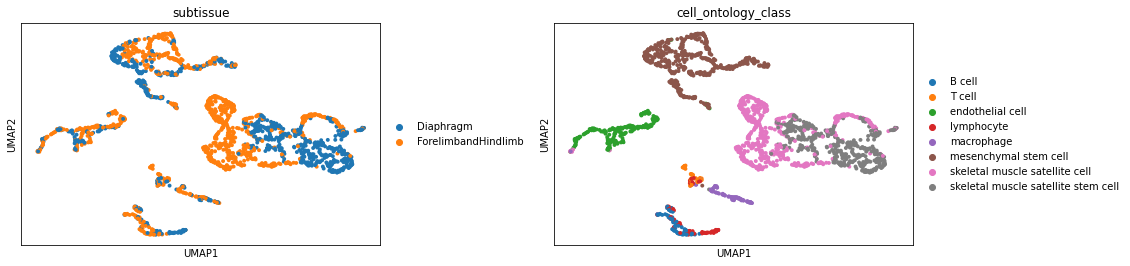

In [3]:
adata = sc.read("./data/limb_sce_alternative.h5ad",)
#adata.X = adata.layers['logcounts']
sc.pp.neighbors(adata, use_rep='UMAP')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['subtissue', 'cell_ontology_class'], wspace=0.35)


         Falling back to preprocessing with `sc.pp.pca` and default params.


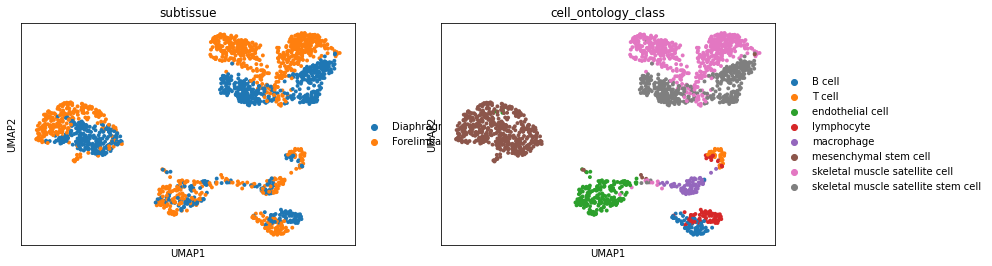

In [4]:
adata = sc.read("./data/limb_sce_alternative.h5ad",)
adata.X = adata.layers['logcounts']
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['subtissue', 'cell_ontology_class'])

In [5]:
adata = sc.read("./data/limb_sce_alternative.h5ad",)
adata.X = adata.layers['logcounts']
enc = OneHotEncoder(sparse=False, dtype=np.float32)
enc.fit(adata.obs['subtissue'].to_numpy()[:,None])
enc_ct = LabelEncoder()
enc_ct.fit(adata.obs['cell_ontology_class'])

use_cuda = torch.cuda.is_available()
convert = {
        'obs' : {
            'subtissue' : lambda s: enc.transform(s.to_numpy()[:, None]),
            'cell_ontology_class': enc_ct.transform,
            }
        }
dataloader = AnnLoader(adata, batch_size=128, shuffle=True, convert=convert,
        use_cuda=use_cuda)

batch = dataloader.dataset[:10]
xdim = batch.X.shape[1]
#ydim = batch.obs['cell_ontology_class'].shape[0]
ydim = batch.obs['subtissue'].shape[1]
print(xdim, ydim)

23433 2


In [15]:
class SigmaVAE2(nn.Module):
    def __init__(
        self,
        nz: int = 20,
        nh: int = 2*1024,
        nx: int = 28 ** 2,
        ny: int = 2,
    ) -> None:
        super(self.__class__, self).__init__()
        self.nx = nx
        self.ny = ny
        self.nz = nz
        self.nin = nx + ny
        nin = nx + ny
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(nin, nh),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=nh),
            nn.Linear(nh, nh),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=nh),
        )
        self.decoder = nn.Sequential(
            nn.Linear(nz+ny, nh),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=nh),
            nn.Linear(nh, nh),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=nh),
        )
        self.xmu = nn.Sequential(
                nn.Linear(nh,nh),
                nn.LeakyReLU(),
                nn.Linear(nh,nx),
                )
        self.zmu =  nn.Sequential(
                nn.Linear(nh,nh),
                nn.LeakyReLU(),
                nn.Linear(nh,nz),
                )
        self.zlogvar =  nn.Sequential(
                nn.Linear(nh,nh),
                nn.LeakyReLU(),
                nn.Linear(nh,nz),
                )
        #self.log_sigma = torch.nn.Parameter(torch.zeros(1)[0], requires_grad=True)
        # per pixel sigma:
        self.log_sigma = torch.nn.Parameter(torch.zeros(nx), requires_grad=True)

    def reparameterize(self, mu, logsig, ):
        eps = torch.randn(mu.shape).to(mu.device)
        sigma = (logsig).exp()
        return mu + sigma * eps

    def encode(self, x,y):
        w = torch.cat((x,y), dim=1)
        h = self.encoder(w)
        mu = self.zmu(h)
        logvar = self.zlogvar(h)
        return mu, logvar

    def decode(self, z, y):
        w = torch.cat((z,y), dim=1)
        h = self.decoder(w)
        mu = self.xmu(h)
        return mu

    def forward(self, x, y):
        zmu, zlogvar = self.encode(x, y)
        z = self.reparameterize(zmu, 0.5*zlogvar)
        xmu = self.decode(z, y)
        return zmu, zlogvar, xmu

    def reconstruction_loss(self, x, xmu, log_sigma):
        # log_sigma is the parameter for 'global' variance on x
        #result = gaussian_nll(xmu, xlogsig, x).sum()
        result = -log_gaussian_prob(x, xmu, log_sigma).sum()
        return result
    
    def loss_function(self, x, xmu, log_sigma, zmu, zlogvar):
        batch_size = x.size(0)
        rec = self.reconstruction_loss(x, xmu, log_sigma) / batch_size
        kl = kld(zmu, zlogvar) / batch_size
        return rec, kl

    def fit(self, train_loader, num_epochs=10, lr=1e-3,
            optimizer = None):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.to(device)
        if not optimizer:
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in range(10):
            #for idx, (data, labels) in enumerate(train_loader):
            for idx, data in enumerate(train_loader):
                self.train()
                self.requires_grad_(True)
                optimizer.zero_grad()
                log_sigma = ut.softclip(self.log_sigma, -2, 2)
                #self.log_sigma.fill_(log_sigma)
                #x = data.flatten(1).to(device)
                x = data.X.float().to(device)
                y = data.obs['subtissue']
                ytarget = torch.argmax(y, dim=1)
                zmu, zlogvar, xmu = self.forward(x,y)
                rec, kl = self.loss_function(x, xmu, log_sigma, zmu, zlogvar)
                loss = rec + kl
                loss.backward()
                optimizer.step()
                if idx % 300 == 0:
                    print("loss = ",
                            loss.item(),
                            kl.item(),
                            rec.item(),
                            )
        self.cpu()
        optimizer = None
        print('done training')
        return None


In [21]:
model2 = SigmaVAE2(nz=20, nh=2048, nx=xdim, ny=ydim)
model2.fit(dataloader)


loss =  71776.421875 0.8306041955947876 71775.59375
loss =  48343.90625 270.97705078125 48072.9296875
loss =  47418.546875 118.59544372558594 47299.953125
loss =  46538.96875 113.36761474609375 46425.6015625
loss =  45783.71484375 93.22380828857422 45690.4921875
loss =  45357.859375 87.74766540527344 45270.11328125
loss =  44346.05859375 79.05770111083984 44267.0
loss =  44097.15625 68.10226440429688 44029.0546875
loss =  43633.5078125 72.1017074584961 43561.40625
loss =  43588.56640625 71.57473754882812 43516.9921875
done training


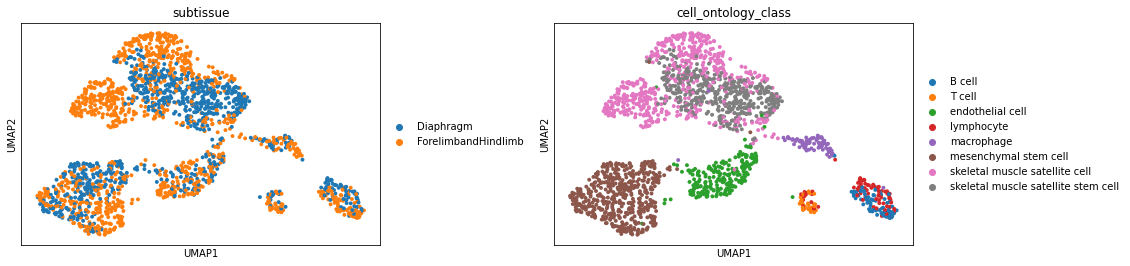

In [22]:
model2.cuda()

mu, logvar = model2.encode(dataloader.dataset[:].X.float(), dataloader.dataset[:].obs['subtissue'])
#adata = sc.read("./data/limb_sce_alternative.h5ad",)
#adata.X = adata.layers['logcounts']

adata.obsm['X_cvae2'] = mu.data.cpu().numpy()

sc.pp.neighbors(adata, use_rep='X_cvae2')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['subtissue', 'cell_ontology_class'], wspace=0.35)


In [26]:
class SigmaVAE(nn.Module):
    def __init__(
        self,
        nz: int = 20,
        nh: int = 2*1024,
        nx: int = 28 ** 2,
        ny: int = 2,
    ) -> None:
        super(self.__class__, self).__init__()
        self.nx = nx
        self.ny = ny
        self.nz = nz
        self.nin = nx + ny
        nin = nx + ny
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(nin, nh),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=nh),
            nn.Linear(nh, nh),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=nh),
        )
        self.decoder = nn.Sequential(
            nn.Linear(nz, nh),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=nh),
            nn.Linear(nh, nh),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=nh),
        )
        self.xmu = nn.Sequential(
                nn.Linear(nh,nh),
                nn.LeakyReLU(),
                nn.Linear(nh,nx),
                )
        self.zmu =  nn.Sequential(
                nn.Linear(nh,nh),
                nn.LeakyReLU(),
                nn.Linear(nh,nz),
                )
        self.zlogvar =  nn.Sequential(
                nn.Linear(nh,nh),
                nn.LeakyReLU(),
                nn.Linear(nh,nz),
                )
        #self.log_sigma = torch.nn.Parameter(torch.zeros(1)[0], requires_grad=True)
        # per pixel sigma:
        self.log_sigma = torch.nn.Parameter(torch.zeros(nx), requires_grad=True)

    def reparameterize(self, mu, logsig, ):
        eps = torch.randn(mu.shape).to(mu.device)
        sigma = (logsig).exp()
        return mu + sigma * eps

    def encode(self, x):
        h = self.encoder(x)
        mu = self.zmu(h)
        logvar = self.zlogvar(h)
        return mu, logvar

    def decode(self, z):
        h = self.decoder(z)
        mu = self.xmu(h)
        return mu

    def forward(self, x):
        zmu, zlogvar = self.encode(x)
        z = self.reparameterize(zmu, 0.5*zlogvar)
        xmu = self.decode(z)
        return zmu, zlogvar, xmu

    def reconstruction_loss(self, x, xmu, log_sigma):
        # log_sigma is the parameter for 'global' variance on x
        #result = gaussian_nll(xmu, xlogsig, x).sum()
        result = -log_gaussian_prob(x, xmu, log_sigma).sum()
        return result
    
    def loss_function(self, x, xmu, log_sigma, zmu, zlogvar):
        batch_size = x.size(0)
        rec = self.reconstruction_loss(x, xmu, log_sigma) / batch_size
        kl = kld(zmu, zlogvar) / batch_size
        return rec, kl

    def init_kmeans(self, nclusters, data):
        """
        initiate the kmeans cluster heads
        """
        self.cpu()
        lattent_data, _ = self.encode(data)
        kmeans = KMeans(nclusters, n_init=20)
        y_pred = kmeans.fit_predict(lattent_data.detach().numpy())
        #self.mu.data.copy_(torch.Tensor(kmeans.cluster_centers_))
        self.y_pred = y_pred
        #self.q = q = self.soft_assign(lattent_data)
        #self.p = p = self.target_distribution(q)
        self.kmeans = kmeans

    def fit(self, train_loader, num_epochs=10, lr=1e-3,
            optimizer = None):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.to(device)
        if not optimizer:
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in range(num_epochs):
            #for idx, (data, labels) in enumerate(train_loader):
            for idx, data in enumerate(train_loader):
                self.train()
                self.requires_grad_(True)
                optimizer.zero_grad()
                log_sigma = ut.softclip(self.log_sigma, -2, 2)
                #self.log_sigma.fill_(log_sigma)
                #x = data.flatten(1).to(device)
                x = data.X.float().to(device)
                zmu, zlogvar, xmu = self.forward(x)
                rec, kl = self.loss_function(x, xmu, log_sigma, zmu, zlogvar)
                loss = rec + kl
                loss.backward()
                optimizer.step()
                if idx % 300 == 0:
                    print("loss = ",
                            loss.item(),
                            kl.item(),
                            rec.item(),
                            )
        self.cpu()
        optimizer = None
        print('done training')
        return None


In [27]:
model = SigmaVAE(nz=20, nh=2048, nx=xdim, ny=0)
model.fit(dataloader, num_epochs=20)


loss =  71044.6171875 1.0460939407348633 71043.5703125
loss =  50648.59375 900.55615234375 49748.0390625
loss =  47086.3515625 189.52499389648438 46896.828125
loss =  46411.25 117.468505859375 46293.78125
loss =  45354.50390625 92.03330993652344 45262.46875
loss =  45492.49609375 79.74514770507812 45412.75
loss =  45114.91796875 78.22805786132812 45036.69140625
loss =  44529.55859375 68.16860961914062 44461.390625
loss =  44337.28515625 76.75566101074219 44260.53125
loss =  43877.46875 93.43321228027344 43784.03515625
loss =  43495.5234375 81.4937973022461 43414.03125
loss =  43214.953125 78.64954376220703 43136.3046875
loss =  42751.03515625 76.86517333984375 42674.171875
loss =  42304.640625 77.64187622070312 42227.0
loss =  42247.4921875 77.14120483398438 42170.3515625
loss =  42223.32421875 73.98868560791016 42149.3359375
loss =  41732.5078125 73.7611083984375 41658.74609375
loss =  41395.88671875 77.53459930419922 41318.3515625
loss =  41242.34765625 77.93397521972656 41164.414062

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.22.1 scipy==1.7.3 pandas==1.4.0 scikit-learn==1.0.2 statsmodels==0.13.1 python-igraph==0.9.9 pynndescent==0.5.6
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


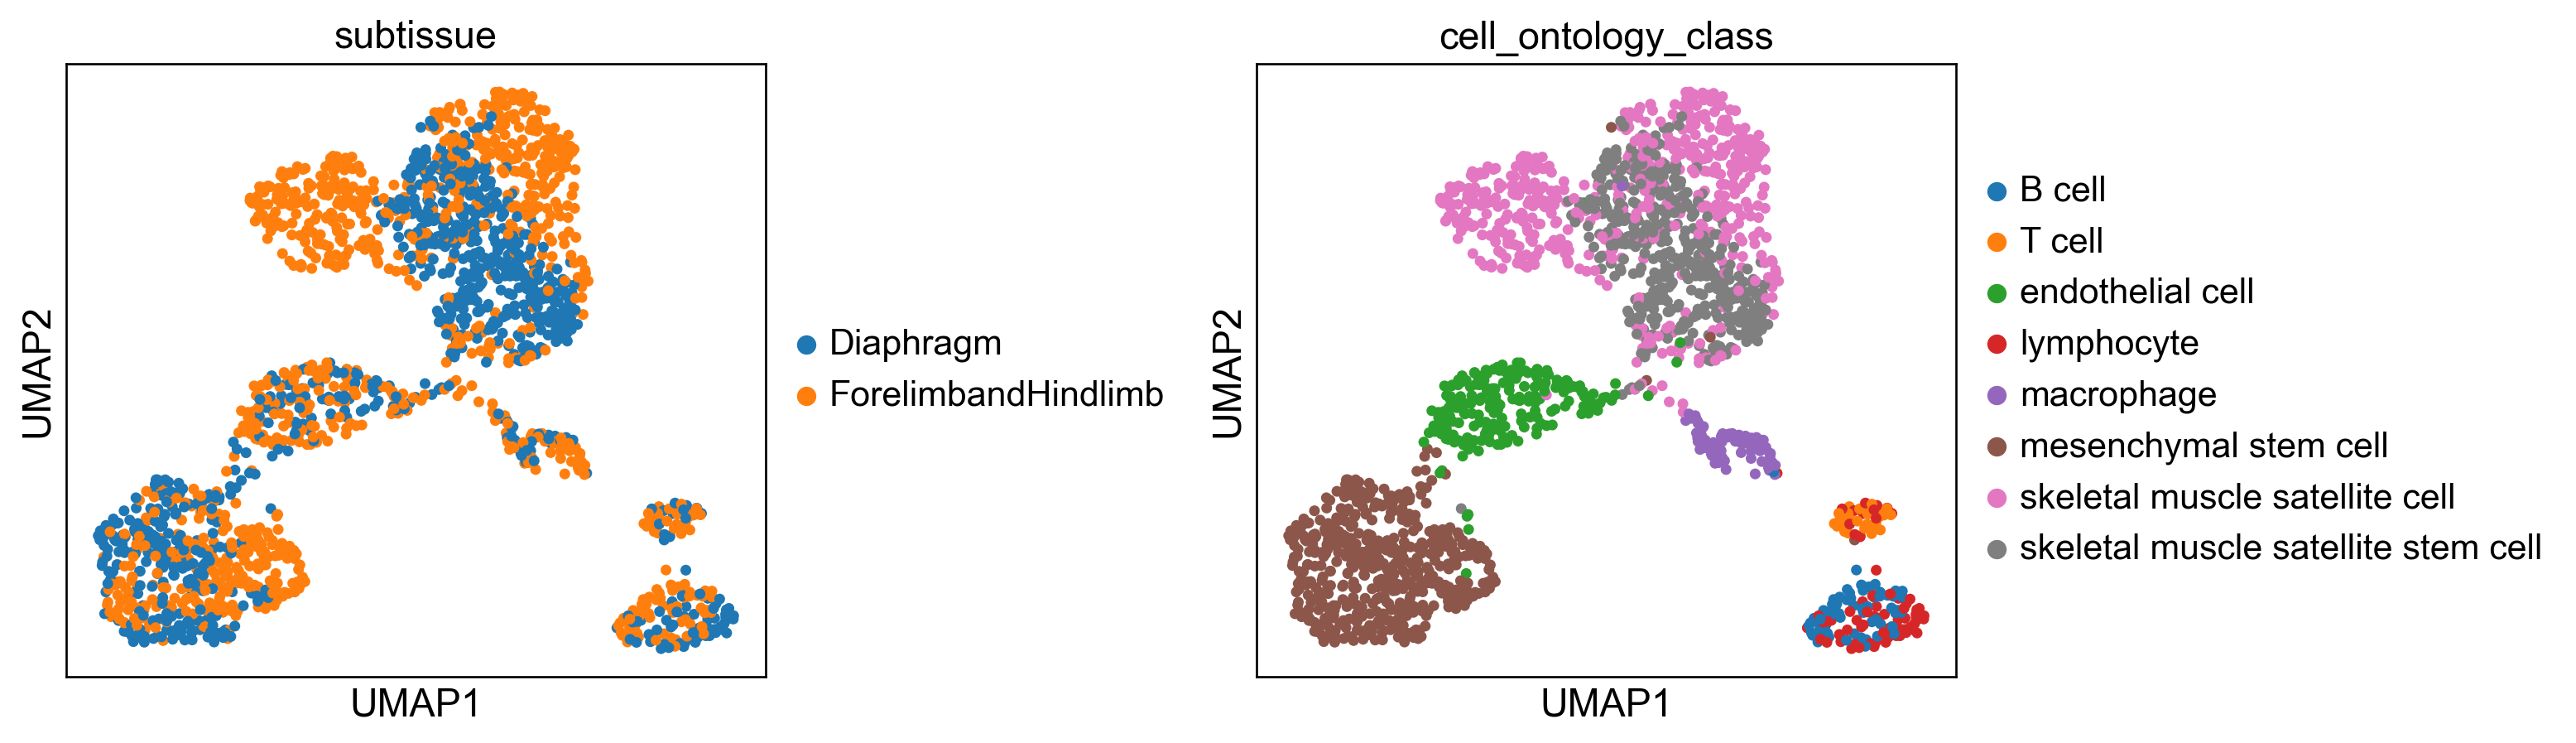

In [35]:
model2.cuda()

mu, logvar = model2.encode(dataloader.dataset[:].X.float(), dataloader.dataset[:].obs['subtissue'])
#adata = sc.read("./data/limb_sce_alternative.h5ad",)
#adata.X = adata.layers['logcounts']

adata.obsm['X_cvae'] = mu.data.cpu().numpy()
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=120, facecolor='white')
sc.pp.neighbors(adata, use_rep='X_cvae')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['subtissue', 'cell_ontology_class'], wspace=0.55)
